<a href="https://colab.research.google.com/github/20188202010/BERT_binary_text_classification/blob/master/BiLstm_CategoryRanking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
import re
import xml.sax.saxutils as saxutils
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk

import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')

nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#read datafolder from Google Drive
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/My Drive/reuters21578/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
sgml_number_of_files = 21
sgml_file_name_template = 'reut2-NNN.sgm'

# Category files
category_files = {
    'to_': ('Topics', 'all-topics-strings.lc.txt'),
    'pl_': ('Places', 'all-places-strings.lc.txt'),
    'pe_': ('People', 'all-people-strings.lc.txt'),
    'or_': ('Organizations', 'all-orgs-strings.lc.txt'),
    'ex_': ('Exchanges', 'all-exchanges-strings.lc.txt')
}

In [0]:
# Create category dataframe

# Read all categories
category_data = []
category_dictionary={'Topics':[],'Places':[],'People':[],'Organizations':[],'Exchanges':[]}
for category_prefix in category_files.keys():
    with open(data_folder + category_files[category_prefix][1], 'r') as file:
        for category in file.readlines():
            category_data.append([category_prefix + category.strip().lower(), 
                                  category_files[category_prefix][0]])

# Create category dataframe
for i in category_data:
#     print(i[1])
    category_dictionary[i[1]].append(i[0].split('_')[1])
news_categories = pd.DataFrame(data=category_data)

# print "category_data: ", category_data
#(news_categories.values).tolist()

In [218]:
print(category_data)

[['to_acq', 'Topics'], ['to_alum', 'Topics'], ['to_austdlr', 'Topics'], ['to_austral', 'Topics'], ['to_barley', 'Topics'], ['to_bfr', 'Topics'], ['to_bop', 'Topics'], ['to_can', 'Topics'], ['to_carcass', 'Topics'], ['to_castor-meal', 'Topics'], ['to_castor-oil', 'Topics'], ['to_castorseed', 'Topics'], ['to_citruspulp', 'Topics'], ['to_cocoa', 'Topics'], ['to_coconut', 'Topics'], ['to_coconut-oil', 'Topics'], ['to_coffee', 'Topics'], ['to_copper', 'Topics'], ['to_copra-cake', 'Topics'], ['to_corn', 'Topics'], ['to_corn-oil', 'Topics'], ['to_cornglutenfeed', 'Topics'], ['to_cotton', 'Topics'], ['to_cotton-meal', 'Topics'], ['to_cotton-oil', 'Topics'], ['to_cottonseed', 'Topics'], ['to_cpi', 'Topics'], ['to_cpu', 'Topics'], ['to_crude', 'Topics'], ['to_cruzado', 'Topics'], ['to_dfl', 'Topics'], ['to_dkr', 'Topics'], ['to_dlr', 'Topics'], ['to_dmk', 'Topics'], ['to_drachma', 'Topics'], ['to_earn', 'Topics'], ['to_escudo', 'Topics'], ['to_f-cattle', 'Topics'], ['to_ffr', 'Topics'], ['to_fis

In [0]:
news_categories.columns = ['category_name', 'category']

In [220]:
print(news_categories)

    category_name   category
0          to_acq     Topics
1         to_alum     Topics
2      to_austdlr     Topics
3      to_austral     Topics
4       to_barley     Topics
..            ...        ...
667       ex_stse  Exchanges
668       ex_tose  Exchanges
669        ex_tse  Exchanges
670        ex_wce  Exchanges
671        ex_zse  Exchanges

[672 rows x 2 columns]


In [221]:
counts = news_categories['category'].value_counts(sort=True).tolist()
indices = news_categories['category'].value_counts(sort=True).index.tolist()
print(counts, indices)

[267, 175, 135, 56, 39] ['People', 'Places', 'Topics', 'Organizations', 'Exchanges']


## Category names in each category

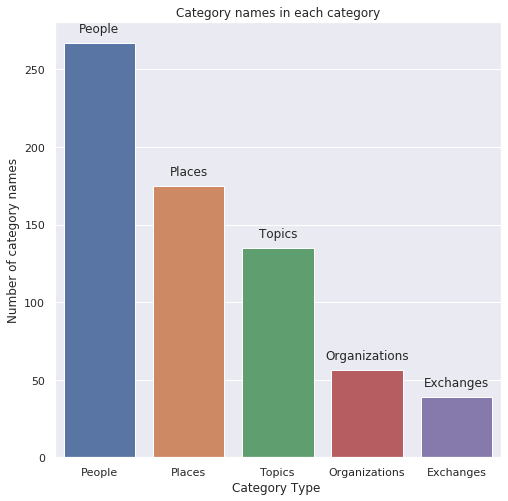

In [222]:
sns.set(font_scale = 1)

plt.figure(figsize=(8,8))
ax= sns.barplot(indices,counts)
plt.title("Category names in each category", fontsize=12)
plt.ylabel('Number of category names', fontsize=12)
plt.xlabel('Category Type ', fontsize=12)#adding the text labels
rects = ax.patches
labels = indices
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)
plt.show()

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 news_categories['category'].unique(),
                                                 news_categories['category'])

In [224]:
news_categories['category'].unique()

array(['Topics', 'Places', 'People', 'Organizations', 'Exchanges'],
      dtype=object)

In [225]:
print(class_weights)
#'Topics','Places','People','Exchanges','Organizations': our order
class_weights = {0:0.9955555,
                 1:0.768 ,
                 2:0.5033,
                 3:3.44615385,
                 4:2.4 }

[0.99555556 0.768      0.50337079 2.4        3.44615385]


## Parsing SGML files

In [0]:
# Parse SGML files
def strip_tags(text):
    return re.sub('<[^<]+?>', '', text).strip()

def unescape(text):
    return saxutils.unescape(text)
  
def makeDict(filename, document_X):
  with open(filename, 'rb') as file:

    content = BeautifulSoup(file.read().lower(),'html.parser')

    for newsline in content('reuters'):
      document_categories = []

      document_id = newsline['newid']
      document_body = strip_tags(str(newsline('text')[0].body)).replace('reuter\n&#3;', '')
      if document_body == 'None':
        continue

      doc_categories = strip_tags(str(newsline('topics')[0].body))
      doc_categories = unescape(doc_categories)

      document_body = unescape(document_body)

      document_X[document_id] = document_body

def readFiles(test_data = False):
  document_X = {}
  
  if test_data == True:
    for i in range(17,22):
      seq = '0' + str(i)
      file_name = sgml_file_name_template.replace('NNN', seq)
      filename = data_folder + file_name
      print('Reading file: %s' % file_name)
      makeDict(filename, document_X)
  else:
    for i in range(17):
      if i < 10:
        seq = '00' + str(i)
      else:
        seq = '0' + str(i)

      file_name = sgml_file_name_template.replace('NNN', seq)
      print('Reading file: %s' % file_name)
      filename = data_folder + file_name
      makeDict(filename, document_X)
  return document_X



## Reading Training files

In [227]:
document_X= readFiles()

Reading file: reut2-000.sgm
Reading file: reut2-001.sgm
Reading file: reut2-002.sgm
Reading file: reut2-003.sgm
Reading file: reut2-004.sgm
Reading file: reut2-005.sgm
Reading file: reut2-006.sgm
Reading file: reut2-007.sgm
Reading file: reut2-008.sgm
Reading file: reut2-009.sgm
Reading file: reut2-010.sgm
Reading file: reut2-011.sgm
Reading file: reut2-012.sgm
Reading file: reut2-013.sgm
Reading file: reut2-014.sgm
Reading file: reut2-015.sgm
Reading file: reut2-016.sgm


In [228]:
print(type(document_X))
print(len(document_X))
print(document_X.keys())
print(document_X['1'])

<class 'dict'>
15057
dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '93', '96', '97', '98', '100', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '130', '131', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '16

## Lemmatize, Tokenize, StopWords Remove

In [0]:
lemmatizer = WordNetLemmatizer()

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;\\n]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def cleanUpSentence(r):#, stop_words = None#
    r = r.lower().replace("<br />", " ")
    r = REPLACE_BY_SPACE_RE.sub(' ', r)
    r = BAD_SYMBOLS_RE.sub('', r)

    r = ' '.join(word for word in r.split() if word not in STOPWORDS)

    words = word_tokenize(r)

    for w in words:
        w = lemmatizer.lemmatize(w)

    return r

In [0]:
def preprocessing(document_X):
    totalX = []
    for i, doc in document_X.items():
        totalX.append(cleanUpSentence(doc))
    return totalX

## Preprocessing Training Data

In [0]:
totalX = preprocessing(document_X)

In [232]:
print(type(totalX))
print(len(totalX))
print(totalX[0])

<class 'list'>
15057
showers continued throughout week bahia cocoa zone alleviating drought since early january improving prospects coming temporao although normal humidity levels restored comissaria smith said weekly review dry period means temporao late year arrivals week ended february 22 155 221 bags 60 kilos making cumulative total season 593 mln 581 stage last year seems cocoa delivered earlier consignment included arrivals figures comissaria smith said still doubt much old crop cocoa still available harvesting practically come end total bahia crop estimates around 64 mln bags sales standing almost 62 mln hundred thousand bags still hands farmers middlemen exporters processors doubts much cocoa would fit export shippers experiencing dificulties obtaining +bahia superior+ certificates view lower quality recent weeks farmers sold good part cocoa held consignment comissaria smith said spot bean prices rose 340 350 cruzados per arroba 15 kilos bean shippers reluctant offer nearby shi

## Dump preprocessed file 

In [0]:

with open(data_folder + 'totalX.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(totalX, filehandle)

## Load Preprocessed file (do this each time)

In [0]:
with open(data_folder + 'totalX.data', 'rb') as filehandle:
    # read the data as binary data stream
    totalX = pickle.load(filehandle)

## visualising - Word Cloud

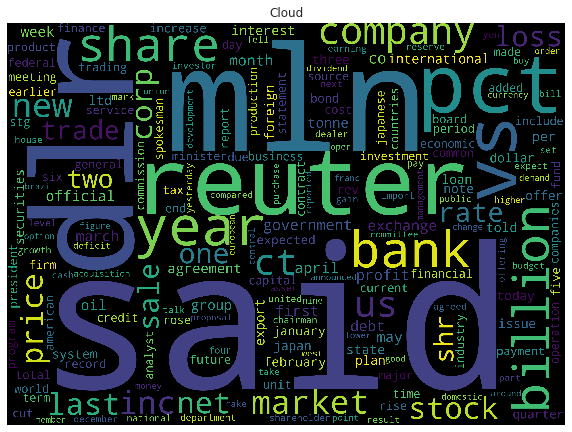

In [235]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(10,15))

text = totalX
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Cloud",fontsize=12)
plt.imshow(cloud)

## Vocabulary 

In [236]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(totalX)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ",vocab_size)

Vocabulary size:  48047


In [237]:
print(tokenizer.word_index.keys())

dict_keys(['said', 'mln', 'dlrs', 'reuter', 'pct', 'vs', '000', 'billion', 'year', 'would', 'us', 'cts', 'company', 'bank', 'new', 'inc', 'last', '1986', 'net', 'corp', 'loss', 'market', 'also', 'one', 'stock', 'shares', '1', 'share', 'trade', 'two', 'april', 'co', 'shr', 'may', 'banks', 'sales', 'march', 'debt', 'first', 'oil', '2', 'government', 'exchange', '1987', 'profit', 'per', 'price', 'prices', 'foreign', 'international', 'tonnes', 'told', 'dlr', 'interest', 'group', 'february', 'agreement', 'years', 'securities', 'ltd', 'rate', 'could', 'three', '1985', '10', '4', 'expected', 'january', 'week', 'due', 'quarter', 'total', 'today', 'president', 'five', '15', 'offer', 'revs', 'japan', 'rose', 'dollar', 'common', 'tax', 'added', 'trading', 'production', 'financial', 'board', 'month', '30', 'capital', 'current', 'rates', 'issue', 'increase', 'economic', 'officials', 'japanese', '8', 'spokesman', '20', 'business', 'made', 'meeting', 'six', 'months', 'major', 'earlier', 'record', 'sy

## Glove Embedding

In [0]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

In [239]:
model = loadGloveModel(data_folder+'glove.6B.50d.txt')

Loading Glove Model
Done. 400000  words loaded!


In [0]:
def get_embedding_matrix(tokenizer,vocab_size, model):
  glove_words =  set(model.keys())
  embedding_matrix = np.zeros((vocab_size, 50))
  cnt=0
  for word, i in tokenizer.word_index.items():
    if word in glove_words:
      embedding_matrix[i] = model[word]
  return embedding_matrix

## Embedding Matrix for Training Data

In [0]:
embedding_matrix_train = get_embedding_matrix(tokenizer,vocab_size,model)

In [242]:
print("Size of embedding matrix to be fed: ", embedding_matrix_train.shape)

Size of embedding matrix to be fed:  (48047, 50)


## Doing Encoding and Padding on Training Data

In [0]:
encoded_articles_train = tokenizer.texts_to_sequences(totalX)

padded_articles_train = pad_sequences(encoded_articles_train,maxlen=50)


In [244]:
print(type(encoded_articles_train))
print(len(encoded_articles_train))
print(encoded_articles_train[0])

<class 'list'>
15057
[7188, 542, 1813, 69, 6714, 835, 2681, 21202, 2231, 139, 229, 68, 2618, 1120, 1111, 6139, 486, 1128, 12377, 401, 5644, 13610, 1507, 1, 1175, 716, 2384, 157, 1033, 6139, 413, 9, 7725, 69, 218, 56, 360, 1584, 4213, 1398, 469, 2746, 520, 1290, 72, 923, 4451, 2, 5219, 1831, 17, 9, 2385, 835, 2039, 108, 12378, 731, 7725, 283, 13610, 1507, 1, 230, 3259, 300, 1773, 556, 835, 230, 256, 4858, 12379, 605, 141, 72, 6714, 556, 878, 186, 1488, 2, 1398, 36, 4452, 875, 1774, 2, 5327, 5491, 1398, 230, 2144, 593, 21203, 1039, 3260, 4636, 300, 835, 10, 4970, 175, 9570, 9571, 28408, 4063, 6714, 4971, 750, 991, 180, 1345, 249, 290, 593, 231, 524, 217, 835, 319, 12378, 13610, 1507, 1, 1399, 7726, 48, 80, 2567, 1115, 7727, 46, 28409, 76, 2746, 7726, 9570, 3682, 77, 2718, 1091, 710, 36, 4972, 37, 1091, 27, 1157, 27, 4064, 3, 46, 717, 2145, 670, 15, 556, 36, 23, 950, 356, 2145, 219, 470, 644, 27, 1918, 27, 5645, 3, 419, 575, 3, 15, 224, 470, 2719, 3261, 27, 3859, 27, 4065, 27, 5645, 3, 46

In [245]:
print(padded_articles_train)

[[   3  760  817 ...   56  424    4]
 [   0    0  492 ...  192  194    4]
 [   0    0    0 ...    3  703    4]
 ...
 [ 387 4528 1090 ...   17    9    4]
 [   0    0    0 ...  530    1    4]
 [1358   39  217 ...   46   28    4]]


In [0]:
#Create one-hot encode
#'Topics', 'Places', 'People', 'Organizations', 'Exchanges' : order in news categories
def makeOneHotEncoding(totalX):
  words_in_body={}

  for i in range(len(totalX)):
      words=totalX[i].split(' ')
      words_in_body[i]=words    

  one_hot_label=[]
  for key,v in words_in_body.items():
      seen_flag = [False] * 5
      #'Topics','Places','People','Exchanges','Organizations': our order
      dict_temp={'Topics':0,'Places':0,'People':0,'Exchanges':0,'Organizations':0}
      for i in v:
          if i in category_dictionary['Topics'] and not seen_flag[0]:
              dict_temp['Topics'] = 1
              seen_flag[0] = True
          if i in category_dictionary['Places'] and not seen_flag[1]:
              dict_temp['Places'] = 1
              seen_flag[1] = True
          if i in category_dictionary['People'] and not seen_flag[2]:
              dict_temp['People'] = 1
              seen_flag[2] = True
          if i in category_dictionary['Exchanges'] and not seen_flag[3]:
              dict_temp['Exchanges'] =1
              seen_flag[3] = True
          if i in category_dictionary['Organizations'] and not seen_flag[4]:
              dict_temp['Organizations'] = 1
              seen_flag[4] = True

      one_hot_label.append(dict_temp)


  one_hot_label_list = []
  for i in one_hot_label:

      one_hot_label_list.append(list(i.values()))
  return one_hot_label_list

## One Hot encoding for Training labels

In [0]:
one_hot_label_list = makeOneHotEncoding(totalX)
#'Topics','Places','People','Exchanges','Organizations'

In [248]:
print(type(one_hot_label_list))
print(len(one_hot_label_list))
print(one_hot_label_list[0])

<class 'list'>
15057
[1, 1, 0, 0, 0]


## BiLSTM MODEL

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Bidirectional, Dropout, Activation
from keras.layers.embeddings import Embedding
from sklearn.utils import class_weight

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_loss'),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [0]:
BiLSTM_model = Sequential()
e = Embedding(vocab_size, 50, weights=[embedding_matrix_train], input_length=50, trainable=False)
BiLSTM_model.add(e)
BiLSTM_model.add(Bidirectional(LSTM(32)))
# BiLSTM_model.add(Dense(16))
# BiLSTM_model.add(Dropout(0.6))
# BiLSTM_model.add(Activation('relu'))
BiLSTM_model.add(Dense(8))
BiLSTM_model.add(Dropout(0.5))
BiLSTM_model.add(Activation('tanh'))
# BiLSTM_model.add(Dense(16))
# BiLSTM_model.add(Dropout(0.5))
# BiLSTM_model.add(Activation('relu'))
BiLSTM_model.add(Dense(5))
BiLSTM_model.add(Activation('sigmoid'))
BiLSTM_model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [392]:
print(BiLSTM_model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 50, 50)            2402350   
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                21248     
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 520       
_________________________________________________________________
dropout_30 (Dropout)         (None, 8)                 0         
_________________________________________________________________
activation_42 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 45        
_________________________________________________________________
activation_43 (Activation)   (None, 5)               

### BiLSTM Training

In [393]:
history = BiLSTM_model.fit(padded_articles_train, 
                           np.array(one_hot_label_list), 
                           epochs=20,
                           batch_size=64, 
                           validation_split=0.3,
                           shuffle=False,# Early stopping,
                           class_weight=class_weights
                         )

Train on 10539 samples, validate on 4518 samples
Epoch 1/20
10539/10539 [==============================] - 18s 2ms/step - loss: 0.5503 - acc: 0.7571 - val_loss: 0.4276 - val_acc: 0.7979
Epoch 2/20
10539/10539 [==============================] - 11s 1ms/step - loss: 0.4743 - acc: 0.8057 - val_loss: 0.3984 - val_acc: 0.8244
Epoch 3/20
10539/10539 [==============================] - 11s 1ms/step - loss: 0.4389 - acc: 0.8190 - val_loss: 0.3934 - val_acc: 0.8263
Epoch 4/20
10539/10539 [==============================] - 11s 1ms/step - loss: 0.4193 - acc: 0.8288 - val_loss: 0.3887 - val_acc: 0.8300
Epoch 5/20
10539/10539 [==============================] - 11s 1ms/step - loss: 0.4069 - acc: 0.8344 - val_loss: 0.3707 - val_acc: 0.8403
Epoch 6/20
10539/10539 [==============================] - 11s 1ms/step - loss: 0.3948 - acc: 0.8406 - val_loss: 0.3782 - val_acc: 0.8392
Epoch 7/20
10539/10539 [==============================] - 11s 1ms/step - loss: 0.3859 - acc: 0.8422 - val_loss: 0.3613 - val_acc:

In [394]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


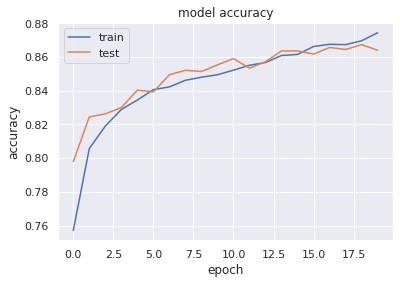

In [395]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

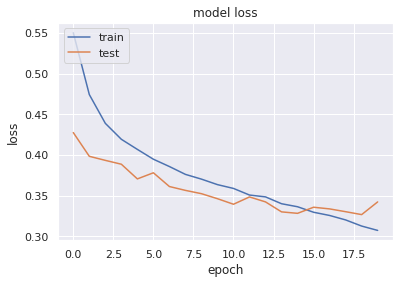

In [396]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Reading Test files

In [397]:
test_document_X = readFiles(test_data=True)

Reading file: reut2-017.sgm
Reading file: reut2-018.sgm
Reading file: reut2-019.sgm
Reading file: reut2-020.sgm
Reading file: reut2-021.sgm


## Preprocessing Test Data

In [0]:
test_total_X = preprocessing(test_document_X)

In [399]:
print(type(test_total_X))
print(len(test_total_X))
print(test_total_X[0])

<class 'list'>
3986
brazilian coffee institute ibc plans sell series auctions next weeks robusta coffee purchased london last year details auctions will take place still finalised ibc president jorio dauster told reporters sales 630 000 bags robusta unspecified amount brazilian arabica coffee will take place minimum six months decided sales will take place whether will held weekly monthly amount offered sale set order 100 000 bags dauster said reuter


## Doing Encoding and Padding on Training Data

In [0]:
encoded_articles_test = tokenizer.texts_to_sequences(test_total_X)
padded_articles_test = pad_sequences(encoded_articles_test,maxlen=50)

In [401]:
print(type(encoded_articles_test))
print(len(encoded_articles_test))
print(encoded_articles_test[0])

<class 'list'>
3986
[794, 432, 913, 4356, 187, 247, 623, 3328, 131, 290, 6912, 432, 1135, 318, 17, 9, 510, 3328, 200, 735, 230, 6878, 4356, 74, 7843, 4113, 52, 491, 36, 4755, 7, 1398, 6912, 3334, 302, 794, 13399, 432, 200, 735, 971, 105, 106, 744, 36, 200, 735, 455, 319, 1175, 1105, 302, 365, 151, 168, 458, 120, 7, 1398, 4113, 1, 4]


In [402]:
print(padded_articles_test)

[[ 1135   318    17 ...  4113     1     4]
 [    0     0     0 ... 21712     1     4]
 [    0     0     0 ...  5244  6892     4]
 ...
 [ 2529  2399  2228 ...   604   132     4]
 [  625   461   680 ...   387  2465     4]
 [  309   164  1017 ...   164  1017     4]]


## One Hot encoding for Test labels

In [0]:
ground_truth_list = makeOneHotEncoding(test_total_X)

In [404]:
print(type(ground_truth_list))
print(len(ground_truth_list))
print(ground_truth_list[0])
#'Topics','Places','People','Exchanges','Organizations'

<class 'list'>
3986
[1, 0, 1, 1, 0]


## Predictions on Test data

In [0]:
predictions = BiLSTM_model.predict(padded_articles_test, batch_size=1)

In [406]:
print(type(predictions))
print(len(predictions))
print(predictions)
#'Topics','Places','People','Exchanges','Organizations'

<class 'numpy.ndarray'>
3986
[[0.58814687 0.24885073 0.117      0.0953039  0.06229986]
 [0.02799257 0.00148673 0.00220959 0.04604249 0.00085117]
 [0.33538574 0.07663334 0.03258944 0.0881153  0.01031662]
 ...
 [0.44905087 0.1512579  0.04340051 0.05715747 0.01381125]
 [0.19792747 0.03679298 0.02941334 0.08712784 0.01816439]
 [0.2536329  0.03167757 0.02638081 0.07971065 0.01056515]]


In [0]:
def convert_prob_to_label(p,mean):
  if p >=mean:
    return 1
  return 0

In [0]:
y_pred_bool = []
for one_list in predictions:
  y_pred_bool_ = [convert_prob_to_label(p,0.5) for p in one_list]
  y_pred_bool.append(y_pred_bool_)

In [409]:
print(y_pred_bool)

[[1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 1, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 1, 1, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 1, 1, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [0, 0, 0, 0, 0], [1, 1, 1, 0, 0], [1, 1, 0, 0, 0], [1, 1, 0, 0, 0], [1, 1, 0, 0, 0], [1, 1, 1, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 1, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 0, 0, 0, 0], [1, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 

## Get Ranked output

In [0]:
def getRankedOutput2(predicted_y):
    all_sorted_x = []
    for i in predicted_y:
        dict_temp={'Topics':i[0],'Places':i[1],'Peoples':i[2],'Exchanges':i[3],'Organizations':i[4]}
        sorted_x = sorted(dict_temp.items(), key=lambda kv: kv[1], reverse=True) 
        all_sorted_x.append(sorted_x)
    return all_sorted_x

In [0]:
predicted_ranked_output = getRankedOutput2(predictions)

In [412]:
print(predicted_ranked_output)

[[('Topics', 0.58814687), ('Places', 0.24885073), ('Peoples', 0.117), ('Exchanges', 0.0953039), ('Organizations', 0.06229986)], [('Exchanges', 0.04604249), ('Topics', 0.027992569), ('Peoples', 0.0022095933), ('Places', 0.0014867336), ('Organizations', 0.00085116806)], [('Topics', 0.33538574), ('Exchanges', 0.088115305), ('Places', 0.07663334), ('Peoples', 0.032589436), ('Organizations', 0.010316617)], [('Topics', 0.2101582), ('Exchanges', 0.04381683), ('Places', 0.022446126), ('Peoples', 0.01216122), ('Organizations', 0.005319903)], [('Topics', 0.25690815), ('Exchanges', 0.020051897), ('Places', 0.018694162), ('Peoples', 0.008043845), ('Organizations', 0.0018696685)], [('Topics', 0.0247919), ('Exchanges', 0.02192115), ('Peoples', 0.0011454663), ('Places', 0.00096936675), ('Organizations', 0.00035799405)], [('Topics', 0.3396957), ('Exchanges', 0.024474056), ('Places', 0.0226078), ('Peoples', 0.012259525), ('Organizations', 0.0024284336)], [('Exchanges', 0.04995626), ('Topics', 0.0376441

In [413]:
labeloutput=[]
id=0
for i in predicted_ranked_output:
  templist=[]
  templist.append(id)
  for j in range(5):
    templist.append(i[j][0])
  id+=1
  labeloutput.append(templist)

col=['Document ID','Category1','Category2','Category3','Category4','Category5']
data=pd.DataFrame(labeloutput,columns=col)
data

,Document ID,Category1,Category2,Category3,Category4,Category5
0,0,Topics,Places,Peoples,Exchanges,Organizations
1,1,Exchanges,Topics,Peoples,Places,Organizations
2,2,Topics,Exchanges,Places,Peoples,Organizations
3,3,Topics,Exchanges,Places,Peoples,Organizations
4,4,Topics,Exchanges,Places,Peoples,Organizations
...,...,...,...,...,...,...
3981,3981,Topics,Places,Peoples,Exchanges,Organizations
3982,3982,Topics,Places,Peoples,Exchanges,Organizations
3983,3983,Topics,Places,Exchanges,Peoples,Organizations
3984,3984,Topics,Exchanges,Places,Peoples,Organizations


## Confusion Matrix

In [0]:
from sklearn.metrics import multilabel_confusion_matrix

In [0]:
y_actual = np.array(ground_truth_list)
y_predict = np.array(y_pred_bool)

In [0]:
matrix = multilabel_confusion_matrix(y_actual, y_predict)

In [417]:
cats = ['Topics','Places','People','Exchanges','Organizations']
print(classification_report(y_actual, y_predict))

              precision    recall  f1-score   support

           0       0.74      0.66      0.69      1698
           1       0.75      0.52      0.62       996
           2       0.58      0.17      0.26       572
           3       0.55      0.02      0.04       281
           4       0.73      0.21      0.33       248

   micro avg       0.73      0.47      0.57      3795
   macro avg       0.67      0.32      0.39      3795
weighted avg       0.70      0.47      0.54      3795
 samples avg       0.28      0.24      0.25      3795



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


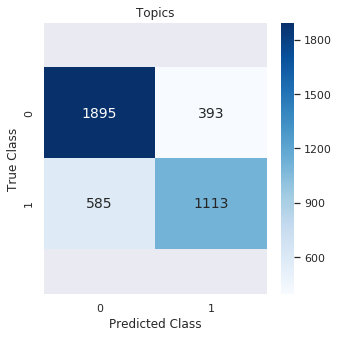

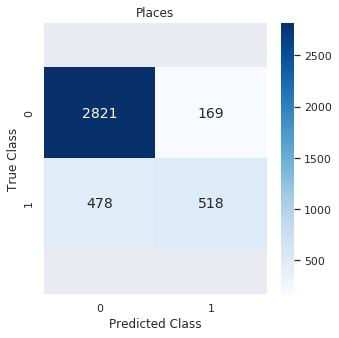

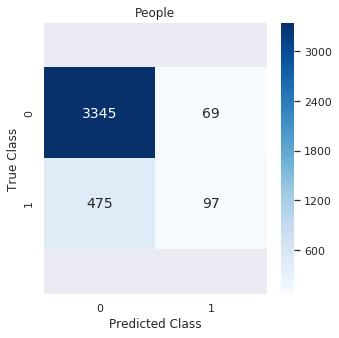

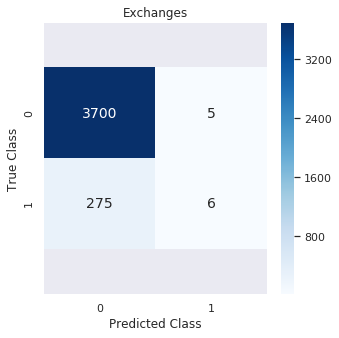

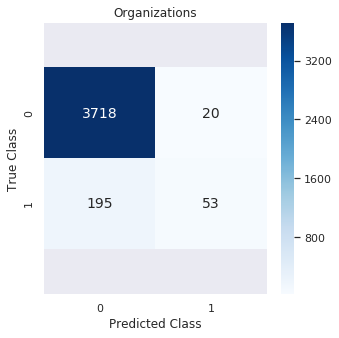

In [418]:
for i in range(5):
  plt.figure(figsize = (5,5))
  ax = sns.heatmap(matrix[i], cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
  bottom, top = ax.get_ylim()
  ax.set_ylim(bottom + 0.5, top - 0.5)
  plt.title(cats[i])
  plt.ylabel('True Class')
  plt.xlabel('Predicted Class')
  plt.show()
